# Flux plots NF2014_AEROFFL
## TOA energy imbalance

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from matplotlib import rcParams
import pandas as pd
import cftime
import glob
import os
import nc_time_axis

In [28]:
rcParams['font.size'] = 20

In [29]:
#define file locations
file_loc1 = '/div/no-backup-nac/users/zofias/NorESM_AEROFFL' #infile path

In [30]:
#select all files with FLNT, FSNT (all aerosol distributions)
pert_file = sorted(glob.glob(f'{file_loc1}/*NT_*pert*ann*'))
base_file = sorted(glob.glob(f'{file_loc1}/*NT_*30Y_0*ann*'))

In [31]:
pert_file

['/div/no-backup-nac/users/zofias/NorESM_AEROFFL/FLNT_NF2014_AEROFFL_30Y_pertG_0001-0030_ann.nc',
 '/div/no-backup-nac/users/zofias/NorESM_AEROFFL/FSNT_NF2014_AEROFFL_30Y_pertG_0001-0030_ann.nc']

In [32]:
#import data
prec_pert = xr.open_mfdataset(pert_file).sel(time=slice('0000-01-01','0030-12-31'))
prec_base = xr.open_mfdataset(base_file).sel(time=slice('0000-01-01','0030-12-31'))

In [33]:
prec_pert

<xarray.Dataset>
Dimensions:    (time: 30, bnds: 2, lon: 144, lat: 96)
Coordinates:
  * time       (time) object 0001-07-01 00:00:00 ... 0030-06-16 00:00:00
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(30, 2), meta=np.ndarray>
    FLNT       (time, lat, lon) float32 dask.array<chunksize=(30, 96, 144), meta=np.ndarray>
    FSNT       (time, lat, lon) float32 dask.array<chunksize=(30, 96, 144), meta=np.ndarray>
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    history:           Mon Aug 11 13:57:20 2025: cdo yearmean /div/no-backup-...
    source:            CAM
    Conventions:       CF-1.0
    case:              NF2014_AEROFFL_30Y_pertG
    logname:           anenj
    initial_file:      /cluster/shared/noresm/inputdata/atm/cam/inic/fv/cami-...
    topography_file:   /cluster/shared/noresm/inputdata/atm/cam/topo/fv_1.9x2...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    frequency:         year
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

In [34]:
#import area dataset #checked same lat lon for NorESM
area_dataset= xr.open_dataset('/div/nac/users/zofias/CESM_output/F2000test/AREA_F2000test_0001-0001_ann.nc')
area_scaling = area_dataset.AREA.isel(time=0)
#print(area_scaling)

In [35]:
#function to calculate net flux and global and arctic means
def netflux(data, area):
    netflux = data['FSNT'] - data['FLNT']
    netflux_glob_mean = netflux.weighted(area).mean(dim=('lat','lon'))
    netflux_arctic_mean = netflux.sel(lat=slice(60,90)).weighted(area.sel(lat=slice(60,90))).mean(dim=('lat','lon'))
    return netflux, netflux_glob_mean, netflux_arctic_mean

In [36]:
calcs = {
    "base": xr.Dataset(),
    "pert": xr.Dataset(),
    "diff": xr.Dataset()
}

models = {
    "base": prec_base,
    "pert": prec_pert,
    "diff": prec_pert - prec_base
}

model_list = ["base", "pert", "diff"]

In [37]:
#calculate net flux and global and arctic mean
for exp in model_list:
    exp_data = models[exp]
    exp_calc = calcs[exp]
    
    exp_calc["net_flux"], exp_calc["net_flux_glob"], exp_calc["net_flux_arctic"] = netflux(exp_data,area_scaling)

In [38]:
calcs['base']

<xarray.Dataset>
Dimensions:          (time: 30, lon: 144, lat: 96)
Coordinates:
  * time             (time) object 0001-07-01 00:00:00 ... 0030-06-16 00:00:00
  * lon              (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat              (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Data variables:
    net_flux         (time, lat, lon) float32 dask.array<chunksize=(30, 96, 144), meta=np.ndarray>
    net_flux_glob    (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>
    net_flux_arctic  (time) float32 dask.array<chunksize=(30,), meta=np.ndarray>

## Flux maps for baseline and perturbation: FLNT, FSNT, net

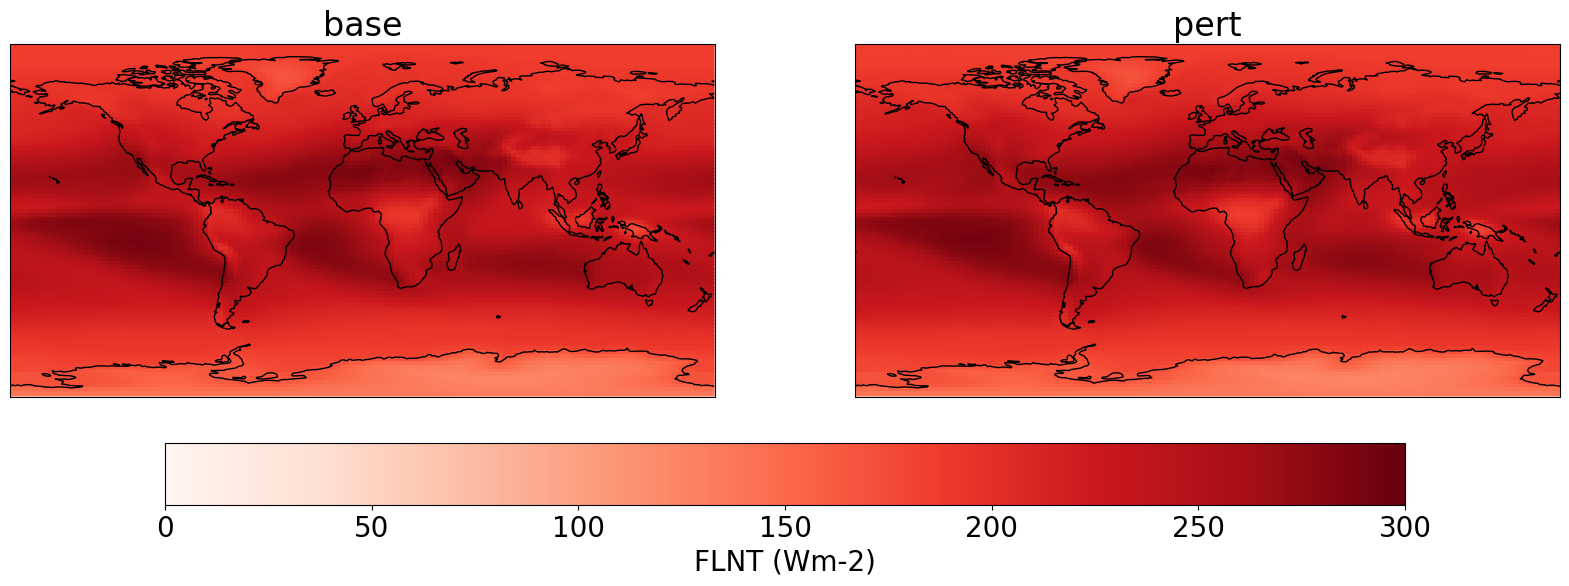

In [48]:
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

fig.set_figheight(12)
fig.set_figwidth(20)

for i,label in enumerate(model_list[:-1]):
    im = models[label].isel(time=slice(10,30)).FLNT.mean(dim='time').plot(
        cmap="Reds",
        ax=axs[i],
        add_colorbar=False,
        vmax=300,
        vmin=0,
        # transform=ccrs.PlateCarree(),  # remember to provide this!
        # #subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
        #cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.05,"label":"SO4 (kg/kg)"},
        # robust=True,
        )

    axs[i].coastlines()
    axs[i].set_title(label)

#cbar_ax = fig.add_axes([0.0, 0.95, 0.05, 0.2])
fig.colorbar(im, ax=axs, shrink=0.8, location='bottom',pad=0.05,label='FLNT (Wm-2)')#, orientation='horizontal', shrink= 0.8, aspect=40,pad=0.05,label='SO4 (kg/kg)')

#for ax, title in zip(fg.axes.flat, time_months):
#    ax.set_title(title)

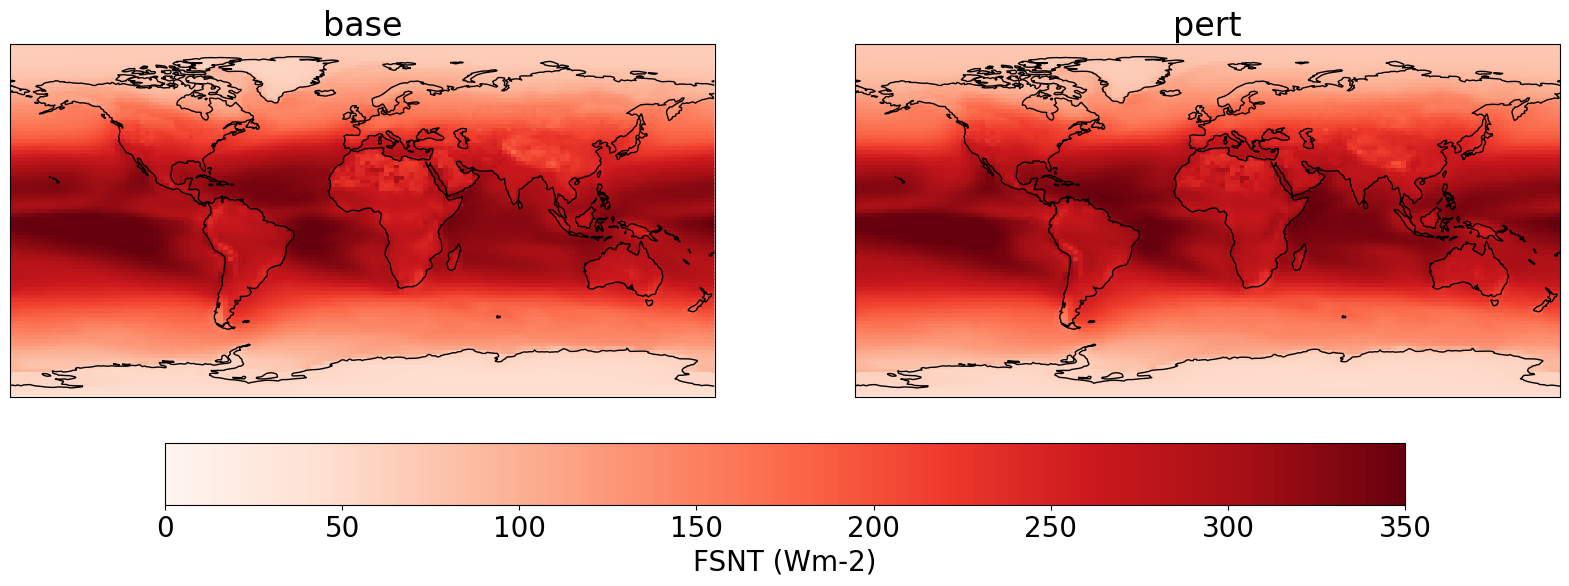

In [49]:
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

fig.set_figheight(12)
fig.set_figwidth(20)

for i,label in enumerate(model_list[:-1]):
    im = models[label].isel(time=slice(10,30)).FSNT.mean(dim='time').plot(
        cmap="Reds",
        ax=axs[i],
        add_colorbar=False,
        vmax=350,
        vmin=0,
        # transform=ccrs.PlateCarree(),  # remember to provide this!
        # #subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
        #cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.05,"label":"SO4 (kg/kg)"},
        # robust=True,
        )

    axs[i].coastlines()
    axs[i].set_title(label)

#cbar_ax = fig.add_axes([0.0, 0.95, 0.05, 0.2])
fig.colorbar(im, ax=axs, shrink=0.8, location='bottom',pad=0.05,label='FSNT (Wm-2)')#, orientation='horizontal', shrink= 0.8, aspect=40,pad=0.05,label='SO4 (kg/kg)')

#for ax, title in zip(fg.axes.flat, time_months):
#    ax.set_title(title)

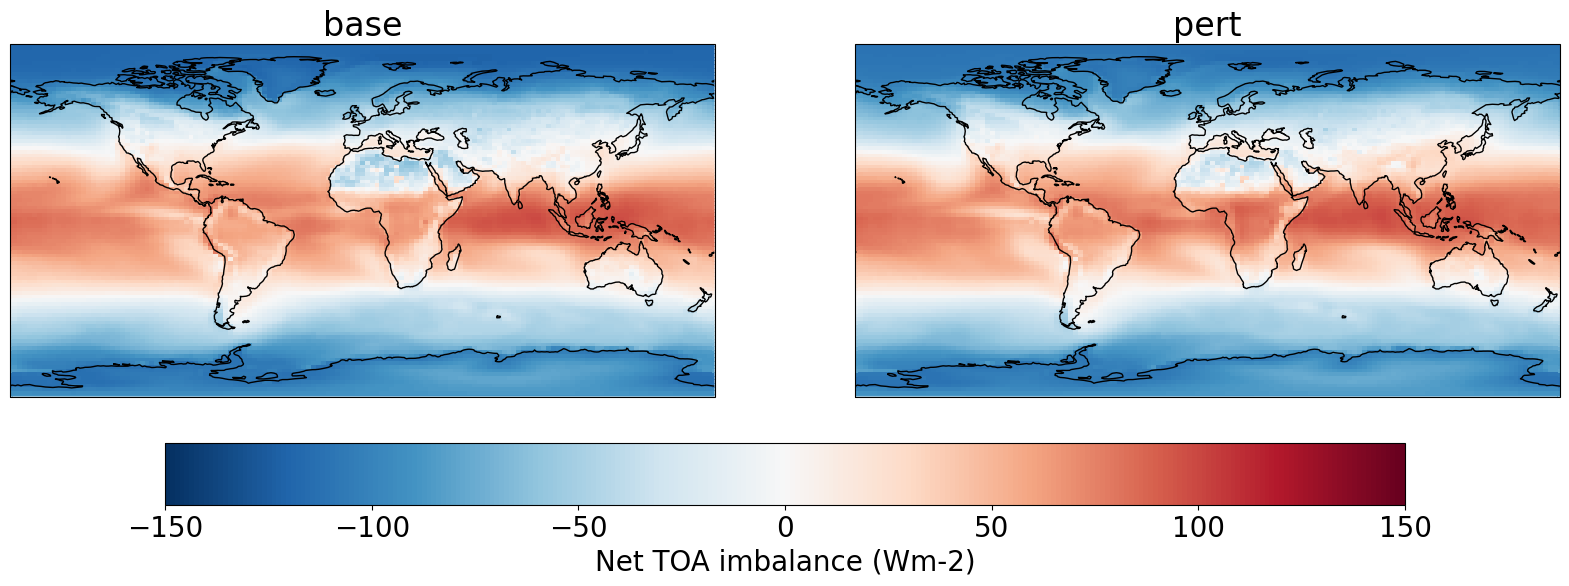

In [50]:
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

fig.set_figheight(12)
fig.set_figwidth(20)

for i,label in enumerate(model_list[:-1]):
    im = calcs[label].isel(time=slice(10,30)).net_flux.mean(dim='time').plot(
        cmap="RdBu_r",
        ax=axs[i],
        add_colorbar=False,
        vmax=150,
        #vmin=0,
        # transform=ccrs.PlateCarree(),  # remember to provide this!
        # #subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
        #cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.05,"label":"SO4 (kg/kg)"},
        # robust=True,
        )

    axs[i].coastlines()
    axs[i].set_title(label)

#cbar_ax = fig.add_axes([0.0, 0.95, 0.05, 0.2])
fig.colorbar(im, ax=axs, shrink=0.8, location='bottom',pad=0.05,label='Net TOA imbalance (Wm-2)')#, orientation='horizontal', shrink= 0.8, aspect=40,pad=0.05,label='SO4 (kg/kg)')

#for ax, title in zip(fg.axes.flat, time_months):
#    ax.set_title(title)

## Flux difference maps

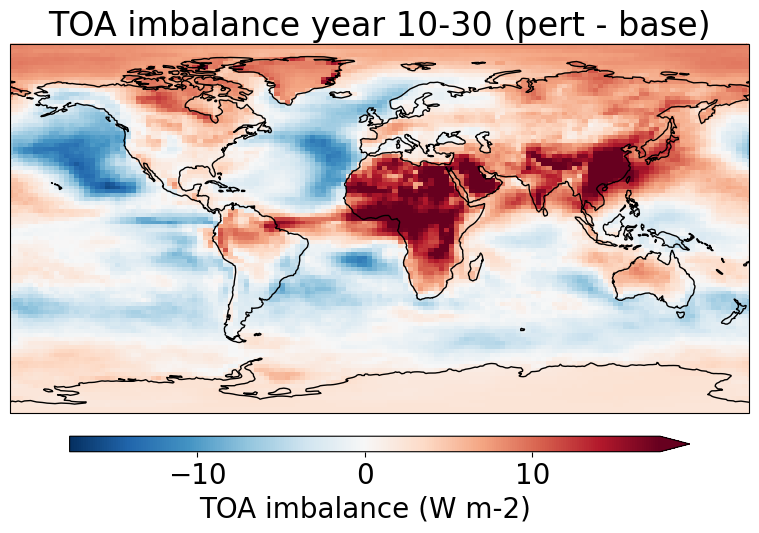

In [42]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

fig.set_figheight(6)
fig.set_figwidth(10)

calcs['diff'].isel(time=slice(10,30)).net_flux.mean(dim='time').plot(
    cmap="RdBu_r",
    ax=axis,
    #vmax=0.01,
    #vmin=0,
    transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.05,"label":"TOA imbalance (W m-2)"},
    robust=True,
)
axis.set_title('TOA imbalance year 10-30 (pert - base)')
axis.coastlines()
#fg.map(lambda: plt.gca().coastlines())
#fg.fig.suptitle('SO4',y=0.97,fontsize=26)

#for ax, title in zip(fg.axes.flat, time_months):
#    ax.set_title(title)

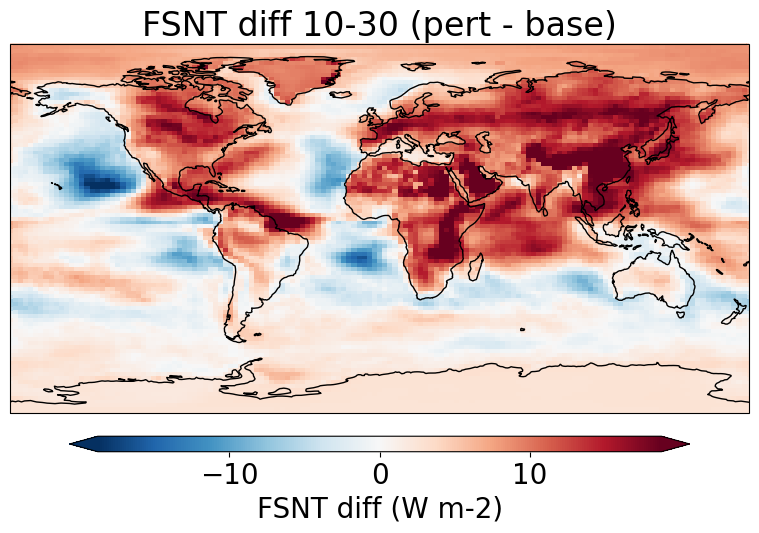

In [43]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

fig.set_figheight(6)
fig.set_figwidth(10)

models['diff'].isel(time=slice(10,30)).FSNT.mean(dim='time').plot(
    cmap="RdBu_r",
    ax=axis,
    #vmax=0.01,
    #vmin=0,
    transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.05,"label":"FSNT diff (W m-2)"},
    robust=True,
)
axis.set_title('FSNT diff 10-30 (pert - base)')
axis.coastlines()
#fg.map(lambda: plt.gca().coastlines())
#fg.fig.suptitle('SO4',y=0.97,fontsize=26)

#for ax, title in zip(fg.axes.flat, time_months):
#    ax.set_title(title)

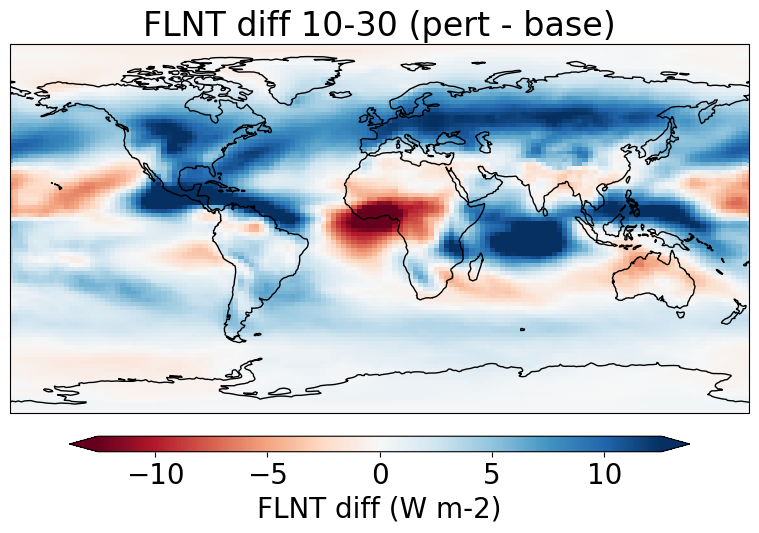

In [44]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

fig.set_figheight(6)
fig.set_figwidth(10)

models['diff'].isel(time=slice(10,30)).FLNT.mean(dim='time').plot(
    cmap="RdBu",
    ax=axis,
    #vmax=0.01,
    #vmin=0,
    transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40,"pad":0.05,"label":"FLNT diff (W m-2)"},
    robust=True,
)
axis.set_title('FLNT diff 10-30 (pert - base)')
axis.coastlines()
#fg.map(lambda: plt.gca().coastlines())
#fg.fig.suptitle('SO4',y=0.97,fontsize=26)

#for ax, title in zip(fg.axes.flat, time_months):
#    ax.set_title(title)

## Mean TOA imbalance plots (time series)

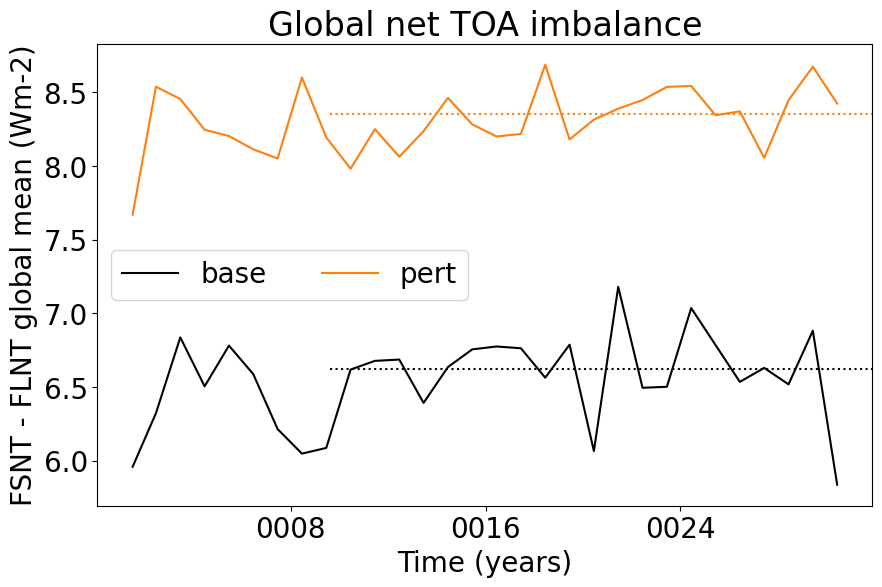

In [46]:
plt.figure(figsize=(10, 6))

calcs['base'].net_flux_glob.plot(label = 'base',c='k')
plt.axhline(y=(calcs['base'].net_flux_glob.isel(time=slice(10,30)).mean()), xmin=0.3, xmax=1, color='k', linestyle=':')
calcs['pert'].net_flux_glob.plot(label = 'pert',c='C1') 
plt.axhline(y=(calcs['pert'].net_flux_glob.isel(time=slice(10,30)).mean()), xmin=0.3, xmax=1,color='C1', linestyle=':')

#calcs['cmip'].net_flux_glob.plot(label = 'cmip',c='C0') 
#plt.axhline(y=(calcs['cmip'].net_flux_glob.isel(time=slice(10,30)).mean()), xmin=0.3, xmax=1,color='C0', linestyle=':')
#calcs['cmip'].bc_mean.isel(lev=0).plot(label = 'BC cmip6',c='C0') 

plt.xlabel('Time (years)')
plt.ylabel('FSNT - FLNT global mean (Wm-2)')
plt.title('Global net TOA imbalance')
plt.legend(ncol=2)
plt.show()

In [47]:
print(f"Global mean net flux (base): {calcs['base'].net_flux_glob.isel(time=slice(10,30)).mean().values:.2f} W m-2")
print(f"Global mean net flux (pert): {calcs['pert'].net_flux_glob.isel(time=slice(10,30)).mean().values:.2f} W m-2")
print()
print(f"Global mean net flux (diff): {calcs['diff'].net_flux_glob.isel(time=slice(10,30)).mean().values:.2f} W m-2")

Global mean net flux (base): 6.63 W m-2
Global mean net flux (pert): 8.36 W m-2

Global mean net flux (diff): 1.73 W m-2


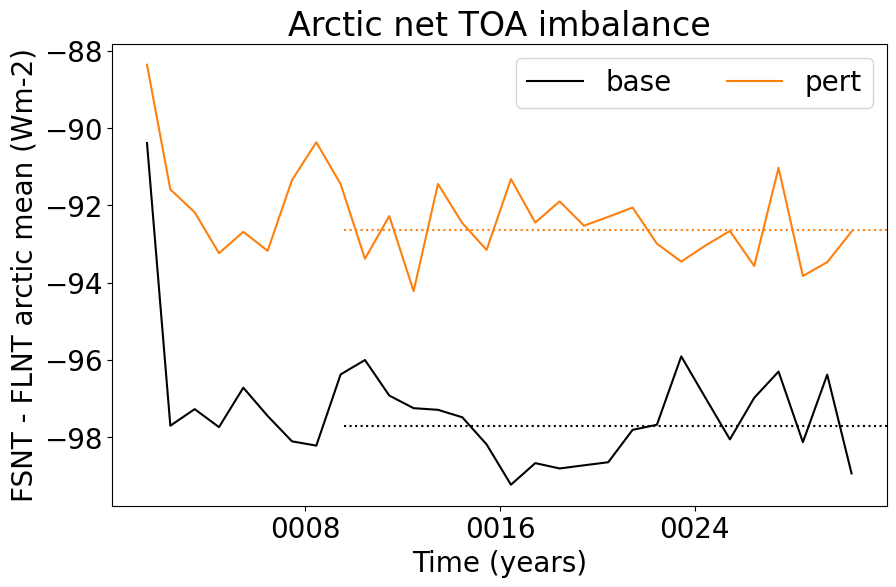

In [51]:
plt.figure(figsize=(10, 6))

calcs['base'].net_flux_arctic.plot(label = 'base',c='k')
plt.axhline(y=(calcs['base'].net_flux_arctic.isel(time=slice(10,30)).mean()), xmin=0.3, xmax=1, color='k', linestyle=':')
calcs['pert'].net_flux_arctic.plot(label = 'pert',c='C1') 
plt.axhline(y=(calcs['pert'].net_flux_arctic.isel(time=slice(10,30)).mean()), xmin=0.3, xmax=1,color='C1', linestyle=':')
#calcs['cmip'].bc_mean.isel(lev=0).plot(label = 'BC cmip6',c='C0') 

plt.xlabel('Time (years)')
plt.ylabel('FSNT - FLNT arctic mean (Wm-2)')
plt.title('Arctic net TOA imbalance')
plt.legend(ncol=2)
plt.show()

In [52]:
print(f"Arctic mean net flux (base): {calcs['base'].net_flux_arctic.isel(time=slice(10,30)).mean().values:.2f} W m-2")
print(f"Arctic mean net flux (pert): {calcs['pert'].net_flux_arctic.isel(time=slice(10,30)).mean().values:.2f} W m-2")
print()
print(f"Arctic mean net flux (diff): {calcs['diff'].net_flux_arctic.isel(time=slice(10,30)).mean().values:.2f} W m-2")

Arctic mean net flux (base): -97.72 W m-2
Arctic mean net flux (pert): -92.64 W m-2

Arctic mean net flux (diff): 5.08 W m-2
